# cramer_lundberg.py
# ------------------------------------------------------------
# Simulation du modèle de ruine de Cramér-Lundberg
# (c) 2025 - Projet pédagogique pour actuaires / data science
# ------------------------------------------------------------
# Dépendances :
#   pip install numpy matplotlib scipy
# Exécution :
#   python cramer_lundberg.py
# ------------------------------------------------------------

In [3]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple, Optional, Dict

# -----------------------------
# 1 Modèle & paramètres
# -----------------------------

In [4]:
@dataclass
class CLParams:
    u: float          # capital initial
    c: float          # taux de primes (par unité de temps)
    lam: float        # intensité de Poisson (fréquence des sinistres)
    sev_sampler: Callable[[int], np.ndarray]  # générateur des montants de sinistres
    T: float          # horizon max de simulation
    # pas de temps (pour l’échantillonnage "continu" entre arrivées);
    # n'intervient que pour le rendu des trajectoires (marche temporelle régulière)
    dt: float = 0.01
    # options de réassurance simples (facultatives)
    quota_share: Optional[float] = None  # p.ex. 0.3 ⇒ cède 30% au réassureur
    stop_loss: Optional[float] = None    # M ⇒ la part au-delà de M est cédée


# -----------------------------
# 2 Lois de sévérité
# -----------------------------

In [8]:
def exp_severity(beta: float) -> Callable[[int], np.ndarray]:
    """Retourne un générateur de montants ~ Exp(beta) (paramètre de taux)."""
    def _sample(n: int) -> np.ndarray:
        return np.random.exponential(scale=1.0 / beta, size=n)
    return _sample

In [9]:
def pareto_severity(alpha: float, xm: float) -> Callable[[int], np.ndarray]:
    """Montants ~ Pareto(x_m, alpha) avec espérance finie si alpha > 1."""
    def _sample(n: int) -> np.ndarray:
        u = np.random.uniform(size=n)
        return xm / (u ** (1.0 / alpha))
    return _sample

In [10]:
def lognormal_severity(mu: float, sigma: float) -> Callable[[int], np.ndarray]:
    """Montants ~ LogN(mu, sigma)."""
    def _sample(n: int) -> np.ndarray:
        return np.random.lognormal(mean=mu, sigma=sigma, size=n)
    return _sample

# -----------------------------
# 3 Utilitaires réassurance
# -----------------------------

In [13]:
def apply_reinsurance(x: np.ndarray,
                      quota_share: Optional[float] = None,
                      stop_loss: Optional[float] = None) -> np.ndarray:
    """
    Transforme les sinistres bruts x en sinistres nets (porteur) après réassurance.
    - quota_share: fraction cédée (0.3 => 30% au réassureur).
    - stop_loss:   plafond M => la part au-delà de M est cédée.
    On applique d'abord la QS, puis le stop-loss sur la part nette.
    """
    net = x.copy()
    if quota_share is not None:
        q = float(quota_share)
        q = max(0.0, min(1.0, q))
        net = (1.0 - q) * net
    if stop_loss is not None:
        M = float(stop_loss)
        # cède (net - M)+
        ceded = np.maximum(net - M, 0.0)
        net = net - ceded
    return net


# -----------------------------
# 4 Simulation d’une trajectoire
# -----------------------------

In [14]:
def simulate_path(params: CLParams,
                  rng: Optional[np.random.Generator] = None
                  ) -> Tuple[np.ndarray, np.ndarray, bool]:
    """
    Simule une trajectoire du capital U(t) jusqu'à T ou jusqu'à ruine.
    Retourne (times, capital, ruined).
    """
    if rng is None:
        rng = np.random.default_rng()

    u, c, lam, T, dt = params.u, params.c, params.lam, params.T, params.dt

    # Génère les instants d'arrivée (processus de Poisson via Inter-arrivals Exp(lam))
    arrivals = []
    t = 0.0
    while t < T:
        ia = rng.exponential(1.0 / lam)
        t += ia
        if t <= T:
            arrivals.append(t)
        else:
            break
    arrivals = np.array(arrivals)

    # Nombre de sinistres
    n_claims = arrivals.size
    # Montants bruts
    X = params.sev_sampler(n_claims)
    # Réassurance (sinistres nets sur le porteur)
    X_net = apply_reinsurance(X, params.quota_share, params.stop_loss)

    # Échantillonnage "régulier" pour tracer la trajectoire
    grid = np.arange(0.0, T + dt, dt)
    U = np.full_like(grid, fill_value=np.nan, dtype=float)
    U[0] = u
    ruined = False

    # capital évolue linéairement entre sinistres (primes) puis chute au sinistre
    current_cap = u
    last_t = 0.0
    claim_idx = 0

    for i, t_grid in enumerate(grid[1:], start=1):
        # Ajoute les primes accumulées sur l'intervalle précédent
        current_cap += c * (t_grid - last_t)
        last_t = t_grid

        # Applique les sinistres qui surviennent dans (grid[i-1], grid[i]]
        while claim_idx < n_claims and arrivals[claim_idx] <= t_grid:
            # avance jusqu'à l'instant du sinistre pour être "exact"
            dt_claim = arrivals[claim_idx] - (t_grid - dt)
            if dt_claim > 0:
                current_cap -= 0.0  # rien de spécial, juste pour clarté
            # chute au sinistre
            current_cap -= X_net[claim_idx]
            claim_idx += 1

        U[i] = current_cap

        if current_cap < 0:
            # ruine au premier passage en dessous de 0 : on peut tronquer la trajectoire
            ruined = True
            U[i:] = current_cap
            break

    return grid, U, ruined



# -----------------------------
# 5 Estimation de proba de ruine
# -----------------------------

In [15]:
def ruin_probability(params: CLParams, n_sims: int = 10_000,
                     seed: Optional[int] = None) -> float:
    """
    Estime par Monte Carlo la probabilité de ruine avant T.
    """
    rng = np.random.default_rng(seed)
    ruined = 0
    for _ in range(n_sims):
        _, _, r = simulate_path(params, rng)
        ruined += int(r)
    return ruined / n_sims




# -----------------------------
# 6 Expériences prêtes à l’emploi
# -----------------------------

In [16]:
def experiment_vary_u(base: CLParams,
                      U_values: Tuple[float, ...] = (50, 100, 150, 200),
                      n_sims: int = 5000,
                      seed: Optional[int] = 123) -> Dict[float, float]:
    """
    Calcule la probabilité de ruine pour différents capitaux initiaux.
    """
    res = {}
    for u in U_values:
        p = ruin_probability(CLParams(
            u=u, c=base.c, lam=base.lam, sev_sampler=base.sev_sampler,
            T=base.T, dt=base.dt,
            quota_share=base.quota_share, stop_loss=base.stop_loss
        ), n_sims=n_sims, seed=seed)
        res[u] = p
    return res


In [17]:
def plot_sample_paths(params: CLParams, n_paths: int = 5, seed: Optional[int] = 42):
    """Trace quelques trajectoires typiques du capital."""
    rng = np.random.default_rng(seed)
    plt.figure(figsize=(9, 5))
    for _ in range(n_paths):
        t, U, r = simulate_path(params, rng)
        plt.plot(t, U, alpha=0.8, linewidth=1.4, label="Ruinée" if r else "Survivante")
    plt.axhline(0.0, linestyle="--", linewidth=1)
    plt.title("Trajectoires typiques du capital U(t)")
    plt.xlabel("Temps")
    plt.ylabel("Capital")
    # légende simple
    handles, labels = plt.gca().get_legend_handles_labels()
    # dédupliquer
    uniq = dict(zip(labels, handles))
    plt.legend(uniq.values(), uniq.keys())
    plt.tight_layout()
    plt.show()

In [18]:
def plot_ruin_vs_u(results: Dict[float, float]):
    """Trace la proba de ruine empirique en fonction du capital initial u."""
    us = np.array(sorted(results.keys()))
    ps = np.array([results[u] for u in us])
    plt.figure(figsize=(7, 4.5))
    plt.plot(us, ps, marker="o")
    plt.title("Probabilité de ruine empirique vs capital initial")
    plt.xlabel("Capital initial u")
    plt.ylabel("Probabilité de ruine")
    plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 7 Main: démo reproductible
# -----------------------------

[1/3] Tracé de trajectoires typiques…


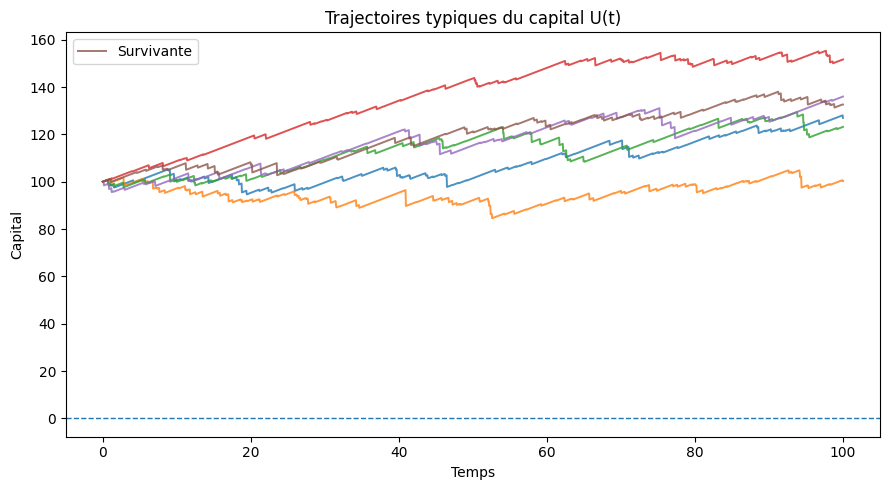

[2/3] Estimation de la probabilité de ruine (u=100)…
  -> Probabilité de ruine empirique (u=100) ≈ 0.0000
[3/3] Courbe proba de ruine selon u…
  u=  50  ->  psi(u) ~ 0.0000
  u=  75  ->  psi(u) ~ 0.0000
  u= 100  ->  psi(u) ~ 0.0000
  u= 125  ->  psi(u) ~ 0.0000
  u= 150  ->  psi(u) ~ 0.0000
  u= 200  ->  psi(u) ~ 0.0000


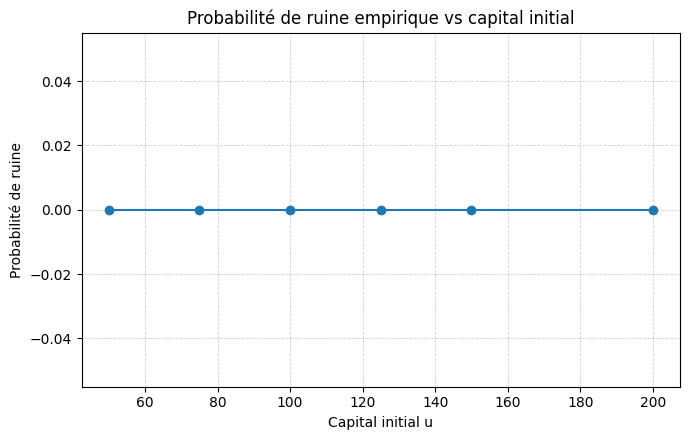

In [19]:
def main():
    np.random.seed(0)

    # --- Paramètres de base (cas exponentiel)
    beta = 1.0          # paramètre de taux de la loi exponentielle
    sev = exp_severity(beta)

    params = CLParams(
        u=100.0,       # capital initial
        c=1.2,         # primes par unité de temps
        lam=0.9,       # fréquence des sinistres
        sev_sampler=sev,
        T=100.0,       # horizon de simulation
        dt=0.05,       # pas pour affichage
        quota_share=None,   # ex: 0.3
        stop_loss=None      # ex: 50.0
    )

    # --- 1) Trajectoires typiques
    print("[1/3] Tracé de trajectoires typiques…")
    plot_sample_paths(params, n_paths=6, seed=123)

    # --- 2) Estimation d'une proba de ruine
    print("[2/3] Estimation de la probabilité de ruine (u=100)…")
    p_ruin = ruin_probability(params, n_sims=10_000, seed=2025)
    print(f"  -> Probabilité de ruine empirique (u=100) ≈ {p_ruin:.4f}")

    # --- 3) Courbe proba de ruine vs capital initial
    print("[3/3] Courbe proba de ruine selon u…")
    results = experiment_vary_u(params, U_values=(50, 75, 100, 125, 150, 200),
                                n_sims=4000, seed=2025)
    for u, p in results.items():
        print(f"  u={u:>4.0f}  ->  psi(u) ~ {p:.4f}")
    plot_ruin_vs_u(results)

    # --- (Optionnel) tester une autre sévérité (Pareto) ou réassurance :
    # params_pareto = params
    # params_pareto.sev_sampler = pareto_severity(alpha=2.0, xm=10.0)
    # params_qs = CLParams(**{**params.__dict__, "quota_share": 0.3})
    # params_sl = CLParams(**{**params.__dict__, "stop_loss": 50.0})


if __name__ == "__main__":
    main()